In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import SeqUtils
import os
import matplotlib.patches as mpatches
import seaborn as sns
from sys import getsizeof
import math
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import scipy.constants
from matplotlib import ticker as mticker
import pickle
from multiprocessing import Pool
import scipy.stats as stats
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import GC

In [4]:
def get_phylum(tax):
    if len(tax.split(';')) > 1:
        phylum = tax.split(';')[1].replace('p__','')
    else:
        phylum = 'NA'
    return(phylum)

In [2]:
#! aws s3 cp s3://florencia-velez/working/
#! aws s3 cp s3://florencia-velez/working/20210519_signalp_analysis/ipynb_out/noTM_nolipo_sec_orfids.txt /home/ec2-user/20210519_signalp_analysis/ipynb_out/noTM_nolipo_sec_orfids.txt
#! aws s3 cp s3://florencia-velez/working/20210519_signalp_analysis/ipynb_out/notsecreted_orfids.txt /home/ec2-user/20210519_signalp_analysis/ipynb_out/notsecreted_orfids.txt
! aws s3 cp s3://florencia-velez/working/20190504_HGM_prodigal/IGG_species_info_23790.tsv    /home/ec2-user/20190504_HGM_prodigal/IGG_species_info_23790.tsv
! aws s3 cp s3://florencia-velez/working/20190504_HGM_prodigal/IGG_genome_info_206581.tsv    /home/ec2-user/20190504_HGM_prodigal/IGG_genome_info_206581.tsv
#! aws s3 cp s3://florencia-velez/working/20200610_metasecretome_figures/ipynb_out/HGM_largecluster_orfs_df.tsv    /home/ec2-user/20200610_metasecretome_figures/ipynb_out/HGM_largecluster_orfs_df.tsv
#! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/HGM_all_genes_lengths.tsv    ipynb_out/HGM_all_genes_lengths.tsv
#! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/HGM_master_sec_nonsec.tsv /home/ec2-user/20210602_metasecretome_figures/ipynb_out/HGM_master_sec_nonsec.tsv

download: s3://florencia-velez/working/20190504_HGM_prodigal/IGG_species_info_23790.tsv to ../20190504_HGM_prodigal/IGG_species_info_23790.tsv
download: s3://florencia-velez/working/20190504_HGM_prodigal/IGG_genome_info_206581.tsv to ../20190504_HGM_prodigal/IGG_genome_info_206581.tsv


In [5]:
# Generate high-quality figure
#Import metadata for HGM MAGs
HGM_species = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_species_info_23790.tsv', sep='\t')
HGM_genomes = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_genome_info_206581.tsv', sep='\t')
HGM_taxinfo = HGM_genomes.set_index('genome_id').join(HGM_species.set_index('species_id'), 'species_id')
HGM_taxinfo['phylum'] = [get_phylum(tax) for tax in HGM_taxinfo['gtdb_taxonomy']]

HGM_species_hqHGM_species = HGM_genomes[(HGM_genomes['repository'] == 'HGM') & (HGM_genomes['quality_level'] == 'high')]['species_id'].tolist()

HGM_species_hqHGM = HGM_species[HGM_species['species_id'].isin(HGM_species_hqHGM_species)]
# Run this so we can get violinplot version

#Limit analysis to bacteria only
bacphy = []
for tax in HGM_species['gtdb_taxonomy']:
    if tax.split(';')[0].replace('d__','') == 'Bacteria' and len(tax.split(';')) > 1:
        bacphy.append(tax.split(';')[1].replace('p__',''))

#ORFids that fall under secreted and non secreted categories as we have newly defined them
#We have excluded MAGs that have < 481 ORFs
#Secreted must have no TM and not be classified as lipoprotein by signalp
#noTM_nolipo_sec_orfids = pd.read_csv('~/20210519_signalp_analysis/ipynb_out/noTM_nolipo_sec_orfids.txt', header=None)[0].tolist()
#notsecreted_orfids = pd.read_csv('~/20210519_signalp_analysis/ipynb_out/notsecreted_orfids.txt', header=None)[0].tolist()

#Import dataframe with all ORFs that are in large clusters in HGM
HGM_largecluster_orfs_df = pd.read_csv('~/20221005_metasecretome_notebooks/ipynb_out/HGM_largecluster_orfs_secpred.tsv',sep='\t')


/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
os.listdir("/home/ec2-user/20220906_HGM_prodigal/prodigal_output_HGM/faa_output/")
with open("/home/ec2-user/20220906_HGM_prodigal/prodigal_output_HGM/faa_output/ERS235496_24.faa") as handle:
    recs = SeqIO.to_dict(SeqIO.parse(handle, 'fasta'))
    print(len(recs.keys()))

1903


In [60]:
#Select MAGs that have at least 481 ORFs
mag_size_dict = dict()
faa_path = "/home/ec2-user/20220906_HGM_prodigal/prodigal_output_HGM/faa_output/"
for mag_faa in os.listdir(faa_path)[:3]:
    with open(faa_path + mag_faa) as handle:
        recs = SeqIO.to_dict(SeqIO.parse(handle, 'fasta'))
        mag_size_dict[mag_faa.replace('.faa','')] = len(recs.keys())
        

(array([6.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 8.000e+00, 1.500e+01,
        3.100e+01, 4.400e+01, 5.900e+01, 8.900e+01, 1.020e+02, 1.000e+02,
        1.320e+02, 2.050e+02, 3.540e+02, 5.810e+02, 7.480e+02, 9.430e+02,
        1.047e+03, 1.055e+03, 1.140e+03, 1.108e+03, 1.051e+03, 1.082e+03,
        1.068e+03, 1.142e+03, 1.086e+03, 1.011e+03, 9.510e+02, 8.350e+02,
        6.770e+02, 5.410e+02, 4.700e+02, 3.840e+02, 3.470e+02, 3.100e+02,
        3.250e+02, 2.520e+02, 2.710e+02, 2.090e+02, 2.300e+02, 1.990e+02,
        1.780e+02, 1.660e+02, 1.390e+02, 1.250e+02, 1.420e+02, 1.610e+02,
        1.750e+02, 1.560e+02, 1.560e+02, 1.550e+02, 1.520e+02, 1.660e+02,
        1.420e+02, 1.250e+02, 1.170e+02, 9.900e+01, 1.170e+02, 1.390e+02,
        1.280e+02, 1.580e+02, 1.230e+02, 1.180e+02, 1.060e+02, 7.700e+01,
        8.100e+01, 7.500e+01, 5.300e+01, 7.600e+01, 5.700e+01, 5.700e+01,
        7.000e+01, 4.000e+01, 3.400e+01, 2.700e+01, 2.800e+01, 2.800e+01,
        1.800e+01, 1.600e+01, 2.300e+0

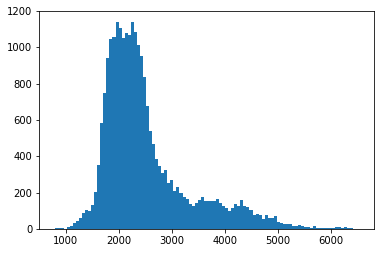

In [16]:
plt.hist(pd.Series(mag_size_dict), bins=100)

In [22]:
HGM_largecluster_orfs_df[HGM_largecluster_orfs_df['secreted'] == 'yes'].orfid.unique().shape

(1627958,)

In [4]:
HGM_largecluster_orfs_df.orfid.unique().shape

(53607501,)

In [43]:
HGM_largecluster_orfs_tax_df = HGM_largecluster_orfs_df.set_index('genomeid').join(HGM_taxinfo['phylum']).reset_index().rename(columns={"index": "genomeid"})

In [44]:
HGM_largecluster_orfs_tax_df[:4]

,genomeid,orfid,clusterid,secreted,Prediction,phylum
0,ERS235496_24,ERS235496_24_k99_12476_24,clusters0,no,Not_secreted,Firmicutes
1,ERS235496_24,ERS235496_24_k99_45601_35,clusters2,no,Not_secreted,Firmicutes
2,ERS235496_24,ERS235496_24_k99_36782_92,clusters3,no,Not_secreted,Firmicutes
3,ERS235496_24,ERS235496_24_k99_36782_111,clusters4,no,Not_secreted,Firmicutes


In [21]:
#Require number of large cluster orfs to be at least 481 so we have a large enough sample to make sure proportion
#of proteome secreted isnt skewed by sampling size
passing_mags = []
grouped = HGM_largecluster_orfs_df.groupby('genomeid')
for name, group in grouped:
    if len(group.orfid.unique().tolist()) >= 481:
        passing_mags.append(name)

,orfid,clusterid,genomeid,secreted,Prediction
0,ERS235496_24_k99_12476_24,clusters0,ERS235496_24,no,Not_secreted
1,ERS235501_56_k99_98957_2,clusters0,ERS235501_56,no,Not_secreted
2,ERS235504_6_k99_4431_112,clusters0,ERS235504_6,no,Not_secreted
3,ERS235508_18_k99_12042_6,clusters0,ERS235508_18,no,Not_secreted


In [7]:
len(passing_mags)

23460

In [8]:
HGM_largecluster_orfs_df.genomeid.unique().shape

(24323,)

In [11]:
23460/24323*100

96.45191793775439

In [31]:
HGM_largecluster_orfs_tax_df[:4]

,orfid,clusterid,secreted,Prediction,phylum
ERS235496_24,ERS235496_24_k99_12476_24,clusters0,no,Not_secreted,Firmicutes
ERS235496_24,ERS235496_24_k99_45601_35,clusters2,no,Not_secreted,Firmicutes
ERS235496_24,ERS235496_24_k99_36782_92,clusters3,no,Not_secreted,Firmicutes
ERS235496_24,ERS235496_24_k99_36782_111,clusters4,no,Not_secreted,Firmicutes


In [45]:
passing_HGM_largecluster_orfs_tax_df = HGM_largecluster_orfs_tax_df[HGM_largecluster_orfs_tax_df['genomeid'].isin(passing_mags)]

In [115]:
os.mkdir('ipynb_out/Figures/')

In [122]:
#Group by phylum
grouped_orfids_byphy = passing_HGM_largecluster_orfs_tax_df.groupby('phylum')

phygenpropsec_df = pd.DataFrame()
topphy = [] #List of phyla that have more than 10 MAGs in Nayfach dataset
ave = dict()
for name, group in grouped_orfids_byphy:
    #print(name)
    phy = name
    if phy in bacphy:
        phygenpropsec = []
        if len(group['genomeid'].unique()) > 10:
            topphy.append(name)
        phygroupgenome = group.groupby('genomeid')
        for name, group in phygroupgenome:
            #print(name)
            phygenpropsec.append(group[group['secreted'] == 'yes'].shape[0]/group.shape[0]*100)
        #newphymags = pd.DataFrame(pd.Series(phygenpropsec, name=phy))
        #phygenpropsec_df = pd.concat([phygenpropsec_df, newphymags], axis=1)
    
    
    ave[phy] = np.average(phygenpropsec)
    phygenpropsec_df = phygenpropsec_df.append(pd.DataFrame({'Phylum':phy, 'Secreted ORFs per MAG (%)':phygenpropsec}))
    
#Order phyla by average secreted proportion of ORFs
orderphy= pd.DataFrame(pd.Series(ave, name='Ave')).sort_values('Ave', ascending=False).index.tolist()

#Make dataframe that only contains phyla that have more than 10 MAGs in dataset
phygenpropsec_df_topphy = phygenpropsec_df[phygenpropsec_df['Phylum'].isin(topphy)]

#Order those phyla too
topphy_orderphy = []
for phy in orderphy:
    if phy in topphy:
        topphy_orderphy.append(phy)


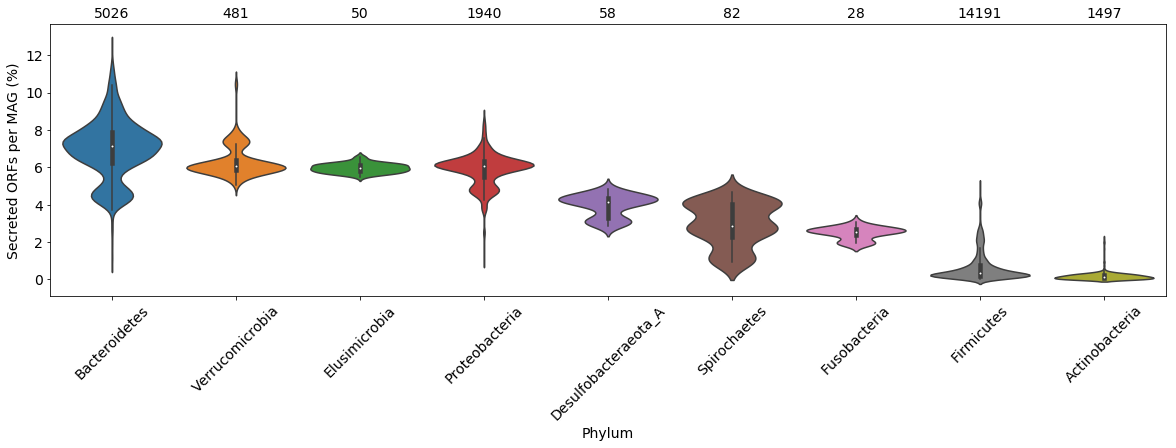

In [123]:
plt.subplots(figsize=[20,5])

sns.violinplot(x='Phylum' ,y='Secreted ORFs per MAG (%)', data=phygenpropsec_df_topphy, scale="width", #width=7.5,
               order=topphy_orderphy)

for phy in topphy_orderphy:
    num_mags = phygenpropsec_df_topphy[phygenpropsec_df_topphy.Phylum == phy].shape[0]
    plt.text(topphy_orderphy.index(phy), 14, str(num_mags), horizontalalignment='center', size='medium', color='black', weight='normal')

plt.rcParams.update({'font.size': 14})
plt.rcParams['svg.fonttype'] = 'none'
plt.xticks(rotation=45)
plt.savefig('ipynb_out/Figures/Fig1_v1_sec_perc_phy_violinplot.svg',format='svg')
plt.show()

In [124]:
#Get orfids for sec or nonsec
def get_orfids():
    HGM_master_sec_nonsec = pd.read_csv('~/20210602_metasecretome_figures/ipynb_out/HGM_master_sec_nonsec.tsv', 
                      sep='\t')
    #
    sec_orfids = HGM_master_sec_nonsec[HGM_master_sec_nonsec['Secreted'] == 'Secreted']['orfid'].tolist()
    nonsec_orfids = HGM_master_sec_nonsec[HGM_master_sec_nonsec['Secreted'] == 'Not Secreted']['orfid'].tolist()
    
    return(sec_orfids, nonsec_orfids)
def get_phygenpropsec(phy):
    phy_list = phygenpropsec_df_topphy[phygenpropsec_df_topphy.Phylum == phy]['Secreted ORFs per MAG (%)'].tolist()
    return(phy_list)
def get_num_mags_in_phy(phy):
    num_mags = phygenpropsec_df_topphy[phygenpropsec_df_topphy.Phylum == phy].shape[0]
    return(num_mags)

In [125]:
scipy.stats.kruskal(get_phygenpropsec("Actinobacteria"),get_phygenpropsec('Bacteroidetes'), get_phygenpropsec('Desulfobacteraeota_A'),
       get_phygenpropsec('Elusimicrobia'), get_phygenpropsec('Firmicutes'), get_phygenpropsec('Fusobacteria'), 
 get_phygenpropsec('Proteobacteria'), get_phygenpropsec('Spirochaetes'), get_phygenpropsec('Verrucomicrobia'))

KruskalResult(statistic=16184.811591032876, pvalue=0.0)

In [126]:
all_phyla = phygenpropsec_df_topphy.Phylum.unique().tolist()

#Filter for phyla with at more than 50 MAGs:
major_phyla = []
for phy in all_phyla:
    if get_num_mags_in_phy(phy) > 50:
        major_phyla.append(phy)

for phy in ['Verrucomicrobia', 'Bacteroidetes']:
    for otherphy in set(major_phyla) - {phy}:
        print("comparing " + phy + " with " + otherphy)
        statres = scipy.stats.mannwhitneyu(x=get_phygenpropsec(phy), y=get_phygenpropsec(otherphy), alternative = 'greater')
        print(statres)
        #Bonferroni correction
        if statres.pvalue < 0.05/20:    
            print("Significant")
            print("Mean of " + phy)
            print(np.mean(get_phygenpropsec(phy)))
            print("Mean of " + otherphy)
            print(np.mean(get_phygenpropsec(otherphy)))
        else:
            print("Not significant")
        print('--')
        

comparing Verrucomicrobia with Actinobacteria
MannwhitneyuResult(statistic=720057.0, pvalue=3.8656858548340785e-240)
Significant
Mean of Verrucomicrobia
6.311387108013541
Mean of Actinobacteria
0.1850311199675443
--
comparing Verrucomicrobia with Bacteroidetes
MannwhitneyuResult(statistic=746524.0, pvalue=1.0)
Not significant
--
comparing Verrucomicrobia with Firmicutes
MannwhitneyuResult(statistic=6825869.0, pvalue=9.480530983882467e-306)
Significant
Mean of Verrucomicrobia
6.311387108013541
Mean of Firmicutes
0.6899029014166135
--
comparing Verrucomicrobia with Desulfobacteraeota_A
MannwhitneyuResult(statistic=27898.0, pvalue=7.07946625772221e-36)
Significant
Mean of Verrucomicrobia
6.311387108013541
Mean of Desulfobacteraeota_A
3.9718503242707315
--
comparing Verrucomicrobia with Proteobacteria
MannwhitneyuResult(statistic=535260.0, pvalue=2.7903563980997764e-07)
Significant
Mean of Verrucomicrobia
6.311387108013541
Mean of Proteobacteria
5.888698499483011
--
comparing Verrucomicrob

In [54]:
#Get orfids for sec or nonsec
def get_orfids():
    #HGM_master_sec_nonsec = pd.read_csv('~/20210602_metasecretome_figures/ipynb_out/HGM_master_sec_nonsec.tsv', 
    #                  sep='\t')
    #
    sec_orfids = passing_HGM_largecluster_orfs_tax_df[passing_HGM_largecluster_orfs_tax_df['secreted'] == 'yes']['orfid'].unique().tolist()
    nonsec_orfids = passing_HGM_largecluster_orfs_tax_df[passing_HGM_largecluster_orfs_tax_df['secreted'] == 'no']['orfid'].unique().tolist()
    
    return(sec_orfids, nonsec_orfids)

def get_lengths():
    #Make record from fasta of all orfs
    record_dict = SeqIO.to_dict(SeqIO.parse('/home/ec2-user/20200128_HGM_Parks_prodigal/HGM_all_genes.faa','fasta'))
    record_dict_keys_list = list(record_dict.keys())

    # If record belongs to large cluster bacterial ORFs in MAGS > 482 ORFs, add id and length to tuple
    orfofint = sec_orfids + nonsec_orfids
    rec_orfofint = list(set(record_dict_keys_list) & set(orfofint))
    HGM_all_genes_lengths_tuple = []

    for orf in rec_orfofint:
        HGM_all_genes_lengths_tuple.append((record_dict[orf].id, len(str(record_dict[orf].seq))))

    pd.DataFrame(HGM_all_genes_lengths_tuple).to_csv('ipynb_out/HGM_all_genes_lengths.tsv', sep='\t', 
                                                     header=['orfid','aa_length'], index=False)
    
def get_length_dict(magid):
    length_dict = dict()
    faa_path = "/home/ec2-user/20220906_HGM_prodigal/prodigal_output_HGM/faa_output/"
    with open(faa_path + magid + '.faa') as handle:
        recs = SeqIO.to_dict(SeqIO.parse(handle, 'fasta'))
    length_dict = {orfid:len(str(recs[orfid].seq).replace('*','')) for orfid in recs.keys()}
    return(length_dict)

def pickle_length_dict(mag):
    dic = get_length_dict(mag)
    pickle.dump( dic, open( "ipynb_out/pickled_length_dictionaries/" + mag + ".p", "wb" ) )

In [127]:
passing_HGM_largecluster_orfs_tax_df.to_csv('ipynb_out/passing_HGM_largecluster_orfs_tax_df.tsv', sep='\t')

In [92]:
os.mkdir("ipynb_out/pickled_length_dictionaries/")

In [95]:
with Pool(28) as p:
    p.map(pickle_length_dict, passing_mags)

In [99]:
passing_mags_length_dict = dict()
for mag in passing_mags:
    passing_mags_length_dict.update(pickle.load( open( "ipynb_out/pickled_length_dictionaries/" + mag + ".p", "rb" ) ))

In [110]:
pickle.dump( passing_mags_length_dict, open( "ipynb_out/HGM_pickled_length_dictionary.p", "wb" ) )

In [55]:
sec_orfids, nonsec_orfids = get_orfids()

In [57]:
len(sec_orfids)

1627156

In [58]:
len(nonsec_orfids)

51884368

In [100]:
sec_orfs_len_dict = {orfid:passing_mags_length_dict[orfid] for orfid in sec_orfids}
nonsec_orfs_len_dict = {orfid:passing_mags_length_dict[orfid] for orfid in nonsec_orfids}

In [108]:
sec_genes_lengths_df = pd.DataFrame(pd.Series(sec_orfs_len_dict, name='aa_length'))
sec_genes_lengths_df['Prediction'] = 'Secreted'

nonsec_genes_lengths_df = pd.DataFrame(pd.Series(nonsec_orfs_len_dict, name='aa_length'))
nonsec_genes_lengths_df['Prediction'] = 'Not Secreted'

HGM_all_genes_lengths_df = sec_genes_lengths_df.append(nonsec_genes_lengths_df)
HGM_all_genes_lengths_df['aa_length(log10)'] = [np.log10(length) for length in HGM_all_genes_lengths_df['aa_length']]

# HGM_all_genes_lengths_df.loc[HGM_all_genes_lengths_df['orfid'].isin(sec_orfids),'Prediction'] = 'Secreted'
# HGM_all_genes_lengths_df.loc[HGM_all_genes_lengths_df['orfid'].isin(nonsec_orfids),'Prediction'] = 'Not Secreted'

# HGM_all_genes_lengths_df['aa_length(log10)'] = [np.log10(length) for length in HGM_all_genes_lengths_df['aa_length']]


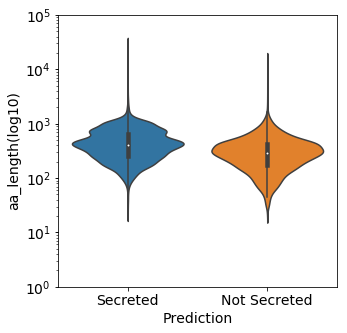

In [119]:
plt.subplots(figsize=[5, 5])
ax = sns.violinplot(x='Prediction' ,y='aa_length(log10)', 
               data=HGM_all_genes_lengths_df, scale="width",
              gridsize=400, bw=0.2)

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax.yaxis.set_ticks([np.log10(x) for p in range(0, 5) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)
plt.savefig('ipynb_out/Figures/Fig1_v1_sec_nonsec_lengthdist_logscale.svg',format='svg')
plt.show()


In [111]:
sec_group = HGM_all_genes_lengths_df[HGM_all_genes_lengths_df['Prediction'] == 'Secreted'].aa_length.tolist()
not_sec_group = HGM_all_genes_lengths_df[HGM_all_genes_lengths_df['Prediction'] == 'Not Secreted'].aa_length.tolist()

In [112]:
np.mean(sec_group)

481.7961559924187

In [113]:
np.mean(not_sec_group)

329.16223728503354

In [114]:
import scipy.stats as stats
t, pvalue = stats.mannwhitneyu(sec_group,not_sec_group, alternative=None)
print(t)
print(pvalue)

28413748214882.0
0.0


In [ ]:
#What is the amino acid cost of secreted proteins compared to non-secreted proteins?

In [133]:
HGM_largecluster_orfs_df[:4]

,orfid,clusterid,genomeid,secreted,Prediction
0,ERS235496_24_k99_12476_24,clusters0,ERS235496_24,no,Not_secreted
1,ERS235501_56_k99_98957_2,clusters0,ERS235501_56,no,Not_secreted
2,ERS235504_6_k99_4431_112,clusters0,ERS235504_6,no,Not_secreted
3,ERS235508_18_k99_12042_6,clusters0,ERS235508_18,no,Not_secreted


In [137]:
! aws s3 cp s3://florencia-velez/working/20210519_signalp_analysis/ipynb_out/representative_hgm_mags.csv representative_hgm_mags.csv

download: s3://florencia-velez/working/20210519_signalp_analysis/ipynb_out/representative_hgm_mags.csv to ./representative_hgm_mags.csv


In [130]:
! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/Suppl_Info/amino_acid_cost_akashi.txt amino_acid_cost_akashi.txt

download: s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/Suppl_Info/amino_acid_cost_akashi.txt to ./amino_acid_cost_akashi.txt


In [20]:
def filter_for_hgm_representative_orfs():
    #HGM_master_sec_nonsec = pd.read_csv('ipynb_out/HGM_master_sec_nonsec.tsv', sep='\t')
    #HGM_master_sec_orfids = HGM_master_sec_nonsec[HGM_master_sec_nonsec['Secreted'] == 'Secreted']['orfid'].tolist()
    #HGM_master_sec_nonsec['genomeid'] = ['_'.join(orfid.split('_')[:2]) for orfid in  HGM_master_sec_nonsec.orfid]

    representative_mags = pd.read_csv('representative_hgm_mags.csv')['genomeid'].unique().tolist()
    HGM_rep_orfs = HGM_largecluster_orfs_df[HGM_largecluster_orfs_df['genomeid'].isin(representative_mags)][['orfid', 'secreted', 'genomeid']]

    #Filter out mags that lack either secreted or non-secreted orfs
    hgm_rep_mags_wnonsec = set(HGM_rep_orfs[HGM_rep_orfs.secreted == 'no'].genomeid.unique())
    hgm_rep_mags_wsec = set(HGM_rep_orfs[HGM_rep_orfs.secreted == 'yes'].genomeid.unique())
    mags_w_both = list(hgm_rep_mags_wnonsec & hgm_rep_mags_wsec) 
    HGM_rep_orfs = HGM_rep_orfs[HGM_rep_orfs.genomeid.isin(mags_w_both)][['orfid', 'secreted', 'genomeid']]
    #Remove one bad orf
    #HGM_rep_orfs = HGM_rep_orfs[HGM_rep_orfs.orfid != "ERS537399_81_kERS537399_9_k99_433_1"]
    return(HGM_rep_orfs)

def calc_protein_cost_by_residue(prot_seq):
    total_cost = 0
    #Remove stop
    prot_seq = prot_seq.replace('*','')
    #Count amino acids
    aa_dist = ProteinAnalysis(prot_seq).count_amino_acids()
    temp = pd.DataFrame(pd.Series(aa_dist, name='Counts')).join(pd.Series(aa_cost_dict, name='Cost'))
    total_cost = np.sum(temp['Counts']*temp['Cost'])
    return(total_cost/len(prot_seq))

def get_dict_mag_cost_by_sec(secretion_status, magid, group): 
    #Secretion status has to be either "Secreted" (yes) or "Not Secreted" (no)
    mag_orfs = group[group.secreted == secretion_status].orfid.tolist()
    cost_orfs = []
    
    fasta_path = "/home/ec2-user/20220906_HGM_prodigal/prodigal_output_HGM/faa_output/" + magid + ".faa"
    mag_faa_dict = SeqIO.to_dict(SeqIO.parse(fasta_path, 'fasta'))        
                
    for key in mag_orfs:
        cost_orfs.append(calc_protein_cost_by_residue(str(mag_faa_dict.get(key).seq)))
    return(cost_orfs)

def orf_cost_per_res_phylum2pickl(name_group_list):
    name = name_group_list[0]
    group = name_group_list[1]
    #Take in name and group and produce pickled dictionary of costs per residue of all proteins in all MAGs in phylum
    orf_cost_dict = dict()
    magid = name
    if not os.path.exists('ipynb_out/hgm_mag_cost_per_res_pickl/' + magid + '.p'):
        cost_nonsec = get_dict_mag_cost_by_sec("no", name, group)
        cost_sec = get_dict_mag_cost_by_sec("yes", name, group)
        orf_cost_dict[magid] = {'no': cost_nonsec, 'yes': cost_sec}

        #Write dictionary of each mag orf costs to pickle
        with open('ipynb_out/hgm_mag_cost_per_res_pickl/' + magid + '.p', 'ab') as magfile:
            pickle.dump(orf_cost_dict[magid], magfile)
            
def calculate_diff_average_cost(mag_cost_dict):
    diff = np.average(mag_cost_dict['yes']) - np.average(mag_cost_dict['no'])
    return(diff)
def calculate_GC_content(magid):
    magid_nuc_seq = SeqIO.parse('/home/ec2-user/20220906_HGM_prodigal/prodigal_output_HGM/fna_output/' + magid + '.fna', 'fasta')
    concat_magid_nuc_seq = ''.join([str(rec.seq) for rec in magid_nuc_seq])
    return(GC(concat_magid_nuc_seq))

In [7]:
#Obtained from Akashi et al (2002) https://doi.org/10.1073/pnas.062526999
aa_cost_dict = pd.read_csv('amino_acid_cost_akashi.txt', sep='\t').set_index('amino acid').to_dict()['cost']

In [8]:
HGM_rep_orfs = filter_for_hgm_representative_orfs()

In [ ]:
os.mkdir('ipynb_out/hgm_mag_cost_per_res_pickl/')

In [9]:
#Calculate for a set of mags, what the cost of secreted orfs is, and what the cost of non-secreted orfs is
#Test on small set of proteins
#somerepprots = HGM_rep_orfs['orfid'].tolist()[:40000]
#grouped = HGM_rep_orfs[HGM_rep_orfs.orfid.isin(somerepprots)].groupby('genomeid')
grouped = HGM_rep_orfs.groupby('genomeid')


In [13]:
#Use more memory, load all orfs into dict and then pull using iterator to calculate amino acid
#percentage
fasta_path = "/home/ec2-user/20220906_HGM_prodigal/prodigal_output_HGM/HGM_all_genes.faa"
hgm_faa_dict = SeqIO.to_dict(SeqIO.parse(fasta_path, 'fasta'))
#dbfile = open('ipynb_out/HGM_all_genes_aa.p', 'rb')
#hgm_faa_dict = pickle.load(open('ipynb_out/HGM_all_genes_aa.p', 'rb'))

In [18]:
#Pool
mags_grouped_list = []
for name, group in grouped:
    mags_grouped_list.append([name, group])

with Pool(24) as p:
    p.map(orf_cost_per_res_phylum2pickl, mags_grouped_list)

In [23]:
#Import pickles
diff_cost_dict = dict()
mag_gc_dict = dict()
for mag_pickle in os.listdir('ipynb_out/hgm_mag_cost_per_res_pickl/'):
    magid = mag_pickle.replace('.p','')
    mag_cost_dict = pickle.load(open('ipynb_out/hgm_mag_cost_per_res_pickl/' + mag_pickle, 'rb'))
    diff_cost_dict[magid] = calculate_diff_average_cost(mag_cost_dict)
    #GC content of MAG versus cost per residue
    mag_gc_dict[magid] = calculate_GC_content(magid)

In [24]:
cost_gc_df = pd.DataFrame(pd.Series(diff_cost_dict, name='Cost_per_residue')).join(pd.Series(mag_gc_dict, name='GC_perc'))
cost_gc_df = cost_gc_df.dropna()

In [30]:
#mag_cost_phy = pd.DataFrame(pd.Series(diff_cost_dict, name='cost_difference')).join(HGM_metadata.loc[list(diff_cost_dict.keys())][['Phylum']])

mag_cost_phy = cost_gc_df.join(HGM_taxinfo.loc[list(diff_cost_dict.keys())][['phylum']])
more_samples_mags = mag_cost_phy.phylum.value_counts()[mag_cost_phy.phylum.value_counts() >= 10].index.tolist()
mag_cost_phy = mag_cost_phy[mag_cost_phy.phylum.isin(more_samples_mags)]
grouped = mag_cost_phy.groupby('phylum')

In [37]:
phyorder = []
cost_dict = dict()
for name, group in mag_cost_phy.groupby('phylum'):
    cost_dict[name] = np.mean(group.Cost_per_residue)
    
phyorder = pd.Series(cost_dict).sort_values(ascending=False).index.tolist()

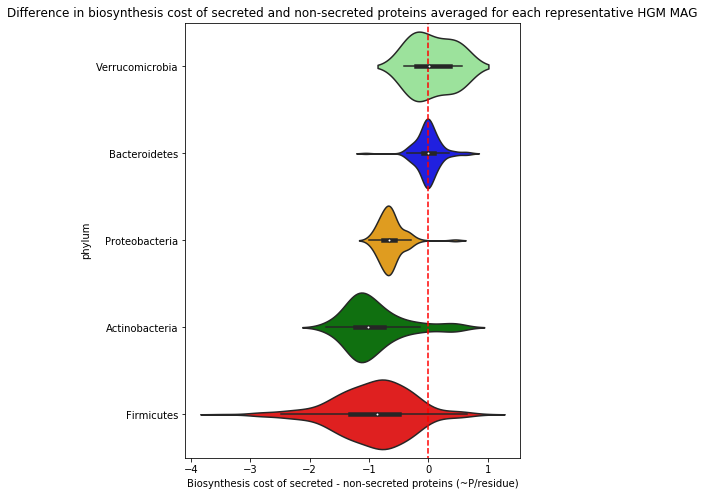

In [39]:
phycoldict = {'Firmicutes': 'red', 
 'Actinobacteria': 'green', 
 'Bacteroidetes': 'blue', 
 'Proteobacteria': 'orange',
       'Verrucomicrobia': 'lightgreen', 
 'Desulfobacteraeota_A': 'lightblue', 
 'Cyanobacteria': 'gray',
       'Fusobacteria': 'purple', 
 'Spirochaetes': 'yellow', 
 'Elusimicrobia': 'pink',
'Epsilonbacteraeota': 'brown'}

plt.subplots(figsize=(6,8))
plt.vlines(x=0, ymin=-1, ymax=11, linestyles='dashed', color='r')
sns.violinplot(x="Cost_per_residue", y="phylum", data=mag_cost_phy.reset_index().drop('index', axis=1), 
               scale="width", palette=phycoldict, order=phyorder)
plt.title('Difference in biosynthesis cost of secreted and non-secreted proteins averaged for each representative HGM MAG')
plt.xlabel('Biosynthesis cost of secreted - non-secreted proteins (~P/residue)')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ipynb_out/Figures/Fig1_v1_costperresidue_phy.svg',format='svg', bbox_inches="tight")

plt.show()